# Credit Card Fraud Detection

This notebook uses predictive models to see how accuracte they are in determing fraud detection on a dataset with financial transactions. The dataset is heavily unbalanced with under 1% of data being fraudulent. We use f1 - score, precision/recall and confusion matrix for metrics (acccuracy score does not perform well on unbalanced datasets). All features in the dataset have been gone through PCA transformation and have been previously scaled.

In [90]:
# Imported Libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [91]:
df = pd.read_csv('../input/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [92]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [93]:
# Check for null values in dataset
df.isnull().sum().max()

0

In [94]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Class Imbalance
We can see how imbalanced the dataset is compared to frauds vs non - fraudulent transactions. Most of the transaction are non - fraud. We can use this dataframe as the base for our predictive models.

In [95]:
# Check for skewed data
print("No Frauds", round(df['Class'].value_counts()[0] / len(df) * 100, 2), "% of the dataset")
print("Frauds", round(df['Class'].value_counts()[1] / len(df) * 100, 2), "% of the dataset")

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Frauds || 1: Fraud)')

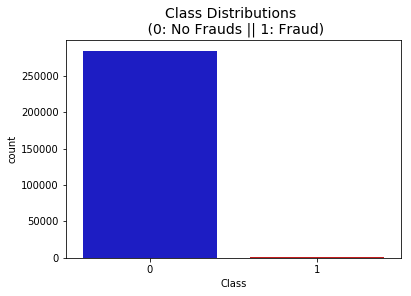

In [96]:
colors = ["#0101DF", "#DF0101"]

sns.countplot("Class", data = df, palette = colors)
plt.title("Class Distributions \n (0: No Frauds || 1: Fraud)", fontsize = 14)

### Distrubtions: 
    - We can see the distributions to see how skewed are the features, we can fix these issues of our features through techniques described further down the notebook.

(0.0, 172792.0)

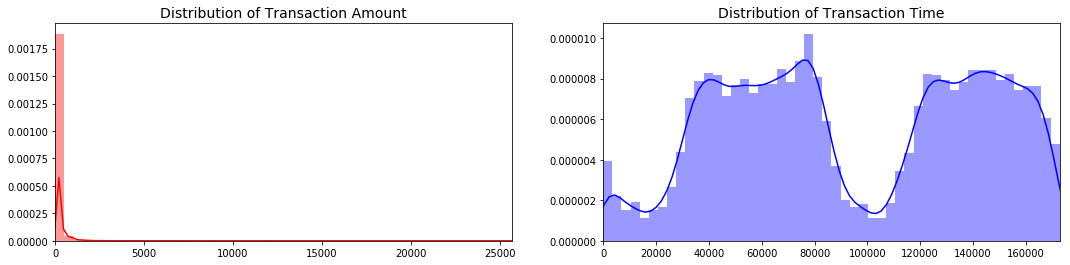

In [97]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

amount_val = df["Amount"].values
time_val = df["Time"].values

sns.distplot(amount_val, ax = ax[0], color = "r")
ax[0].set_title("Distribution of Transaction Amount", fontsize = 14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax = ax[1], color = "b")
ax[1].set_title("Distribution of Transaction Time", fontsize = 14)
ax[1].set_xlim([min(time_val), max(time_val)])

## Scaling and Distributing

We can scale out the columns Time and Amount. We need to create a subsample of the dataframe to have equal amounts of fraud and non - frauds. This helps our ML algorithms better understand patterns that determine whether a transation is fraud or not fraud.

The subsample we will use will be a 50/50 split of fraud and non fraud transactions. 

### The following issues are caused by class imbalance: 
 - Overfitting: Since the original dataset is heavily skewed, most of our models would assume there would be no fraud occuring. 
 - Wrong Correlations: We do not know what the features stand for, they are protected privately and have and PCA performed on them. By having an imbalanced dataframe, we would not be able to see the class and features.
 
### Outcome: 
 - Scaled amount and scaled time
 - 492 cases of fraud in our dataset and 492 cases on non fraud to create new sub dataframe

In [98]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Robust scaler is less prone to outliers
rob_scaler = RobustScaler()

df["scaled_amount"] = rob_scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["scaled_time"] = rob_scaler.fit_transform(df["Time"].values.reshape(-1, 1))

In [99]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960


### Split the Data 

For testing purposes we need to split the data to train/test splits. We can use startified sampling with test split 20%. It is important to note we need to do this before using oversampling/undersampling techniques to help improve the class imbalane of the datasets.

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print("No Frauds", round(df["Class"].value_counts()[0]/len(df) * 100, 2), "% of the dataset")
print("Frauds", round(df["Class"].value_counts()[1]/len(df) * 100, 2), "% of the dataset")

X = df.drop("Class", axis = 1)
y = df["Class"]

sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X, y):
    original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
    original_Y_train, original_Y_test = y.iloc[train_index], y.iloc[test_index]

original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_Y_train = original_Y_train.values
original_Y_test = original_Y_test.values

    
train_label_unique, train_counts_label = np.unique(original_Y_train, return_counts = True)
test_label_unique, test_counts_label = np.unique(original_Y_test, return_counts = True)
print("-" * 100)

print("Label Distributions: \n")
print(train_counts_label / len(original_Y_train))
print(test_counts_label / len(original_Y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under Sampling

Remove data in order to have a more balanced dataset and avoid models to overfit. This can lead to information loss (492 transactions from 284,315 transactions). This can degrade model performance but acts as a good baseline metric.

In [101]:
df = df.sample(frac = 1)

fraud_df = df.loc[df["Class"] == 1]
non_fraud_df = df.loc[df["Class"] == 0][:492]

normal_distribution_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distribution_df.sample(frac = 1, random_state = 42)
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
25932,33833.0,-5.550613,4.066990,-2.719127,-1.691664,0.184231,5.710606,-5.043426,-8.954302,-0.802917,1.456367,-1.080398,0.786295,0.103497,1.323456,0.483974,-0.742121,0.661582,2.085781,-0.834727,-2.951028,10.491254,-4.408019,1.554263,0.741285,0.254942,-0.432106,-0.157066,0.140886,30.00,0,0.111786,-0.597505
240222,150494.0,1.852889,1.069593,-1.776101,4.617410,0.770413,-0.400859,-0.040970,0.089510,-0.217705,-0.373927,-0.688454,-1.463207,-1.624155,-4.252466,-1.340176,1.732873,2.934481,1.437197,-1.923309,-0.288392,-0.157869,-0.176244,0.027437,-0.468006,0.058063,0.148263,0.042278,0.040573,1.00,1,-0.293440,0.773059
260214,159453.0,1.836850,-1.264678,-0.956398,-0.300114,-1.113493,-0.975865,-0.346994,-0.210688,-0.195346,0.824259,-1.206277,-0.718967,-1.038266,0.411973,0.617815,-1.052280,-0.187008,0.738174,-0.648160,-0.357112,-0.764767,-2.157937,0.480418,-0.232296,-0.905486,0.025221,-0.079366,-0.018872,172.75,0,2.106477,0.878312
42007,40918.0,-3.140260,3.367342,-2.778931,3.859701,-1.159518,-0.721552,-4.195342,-0.598346,-2.870145,-5.290610,3.823762,-7.492276,-1.524367,-8.527679,-0.391215,-6.180880,-9.698839,-4.818233,-0.871582,0.077781,2.452339,-0.292963,-0.189330,-0.166482,0.038040,-0.015477,0.776691,0.397557,0.76,1,-0.296793,-0.514268
17317,28625.0,-27.848181,15.598193,-28.923756,6.418442,-20.346228,-4.828202,-19.210896,18.329406,-3.668735,-8.009159,4.303096,-6.008660,1.138969,-5.580447,-0.110737,-5.491073,-11.588544,-4.715420,0.734573,1.697856,1.802149,-2.062934,-1.269843,0.165409,1.999499,-0.211059,1.324809,0.388090,99.99,1,1.089779,-0.658690


Distribution of the classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


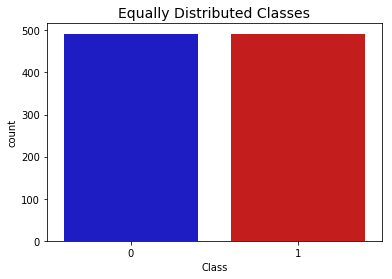

In [102]:
print("Distribution of the classes in the subsample dataset")
print(new_df["Class"].value_counts() / len(new_df))

sns.countplot("Class", data = new_df, palette = colors)
plt.title("Equally Distributed Classes", fontsize = 14)
plt.show()

### Correlation Matricies

To better understand our data we can check the correlations between our features. We want to focus on determing if there are features that influence whether a transaction is fraud or not. We will need to use the subsample dataframe otherwise the class imbalances will effect the results.

#### Summary:
 - Negative correlations: V14, V12, V10, V17 are all negativly correlated.
 - Positive correlations: V2, V4, V11, V19 are all positively correlated. 

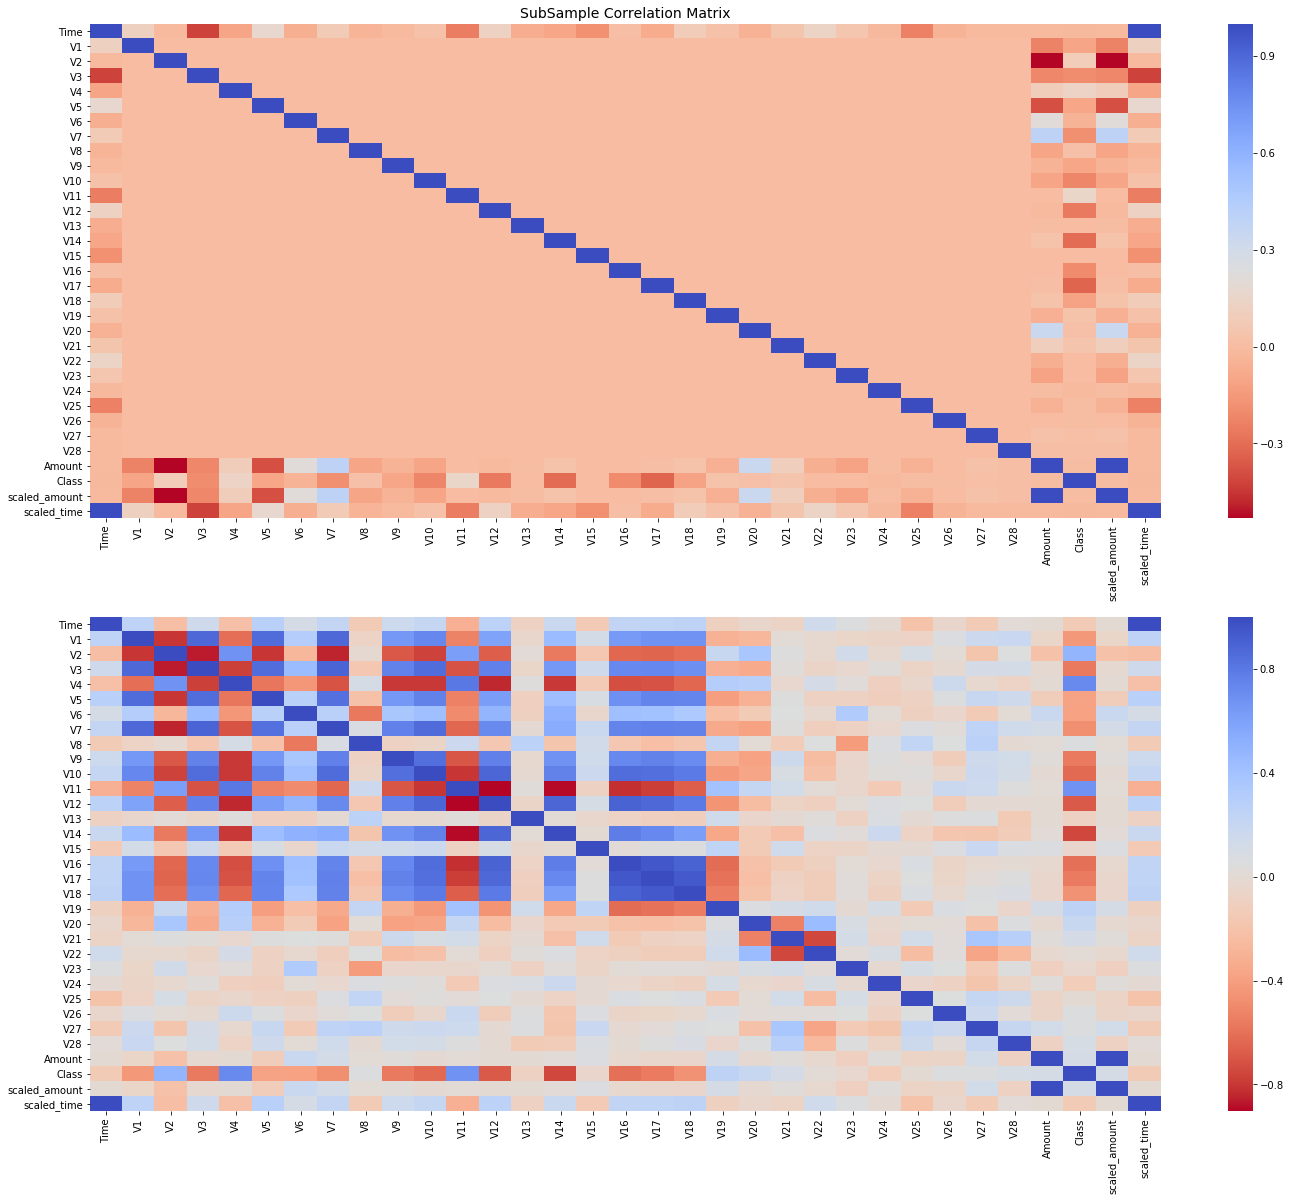

In [103]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (24, 20))
corr = df.corr()
sns.heatmap(corr, cmap = "coolwarm_r", annot_kws = {"size": 20}, ax = ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize = 14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap = "coolwarm_r", annot_kws = {"size": 20}, ax = ax2)
ax1.set_title("SubSample Correlation Matrix", fontsize = 14)
plt.show()

### Anomaly Detection 

This can remove outliers in our dataset, removing data from features that have a high correlation with classes. This will increase the score in our metrics for our models.

#### Dimensionality Reduction and Clustering

ML algorithm: t - SNE

    - T - SNE can quickly cluster the cases that were fraud and non fraud in dataset
    - Accurate measure for algorithm to detect clusters
    - Gives indication that further models can perform pretty well in seperating fraud from non fraud cases. 

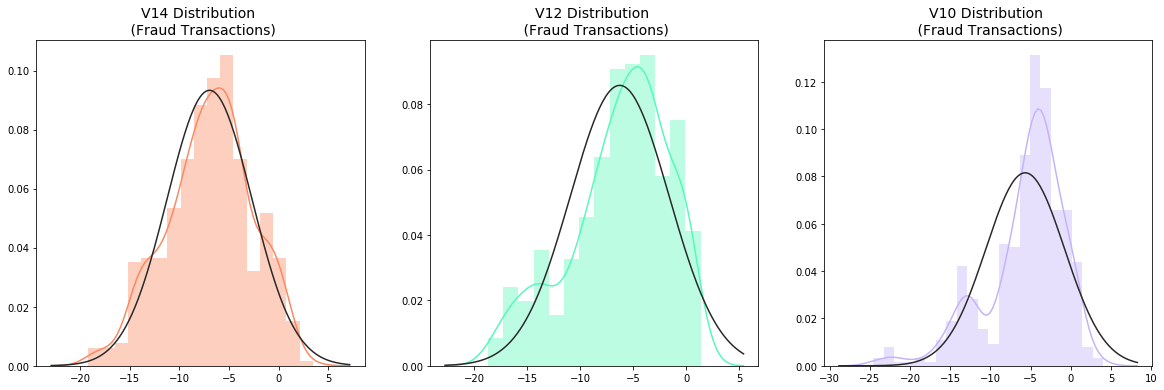

In [104]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [105]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.8220867423816, -18.049997689859396, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.553697009645802, -18.683714633344298, -18.047596570821604, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-19.836148851696, -2

In [106]:
# new_df from undersample method
X = new_df.drop("Class", axis = 1)
y = new_df["Class"]

# T - SNE 
t0 = time.time()
X_reduced_tnse = TSNE(n_components = 2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA 
t0 = time.time()
X_reduced_pca = PCA(n_components = 2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components = 2, algorithm = "randomized", random_state = 42).fit_transform(X.values)
t1= time.time()
print("Truncated SVD took {:.2} s".format(t1- t0))

T-SNE took 4.4 s
PCA took 0.0059 s
Truncated SVD took 0.0048 s


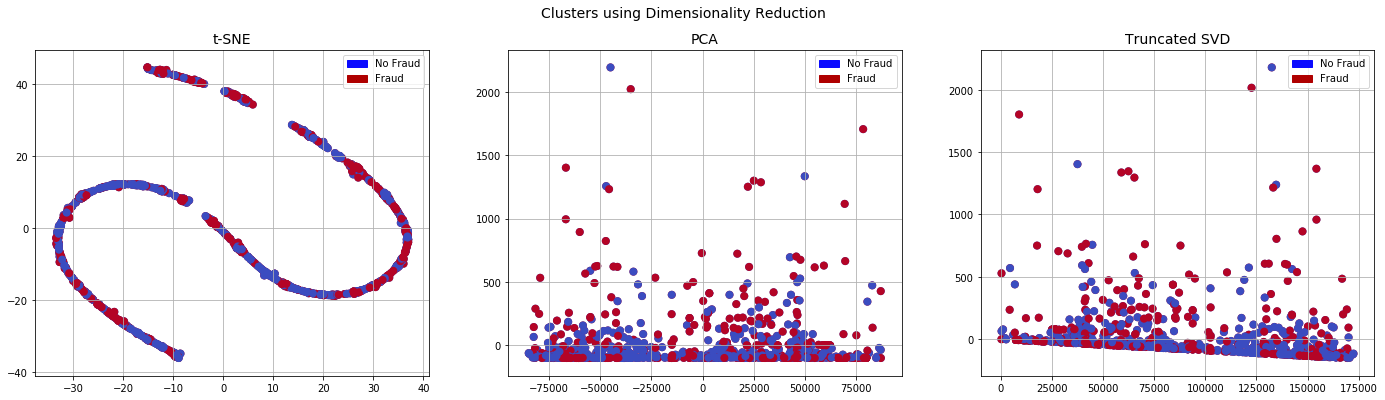

In [107]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tnse[:,0], X_reduced_tnse[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tnse[:,0], X_reduced_tnse[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### Classifiers (UnderSampling)

We can train four types of classifiers and decide which classifier will be the most effective in detecting fraud transactions. 

In [108]:
# Undersampling before cross validation
X = new_df.drop("Class", axis = 1)
y = new_df["Class"]

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [110]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [111]:
classifiers = {
    "logistic_regression": LogisticRegression(),
    "knearest": KNeighborsClassifier(),
    "svm": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [112]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv = 5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 65.0 % accuracy score
Classifiers:  SVC Has a training score of 55.00000000000001 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 93.0 % accuracy score


In [113]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.1, 1]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [114]:
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [115]:
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

In [116]:
# # DecisionTree Classifier
# tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
#               "min_samples_leaf": list(range(5,7,1))}
# grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
# grid_tree.fit(X_train, y_train)

In [117]:
# # tree best estimator
# tree_clf = grid_tree.best_estimator_

In [118]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_X_train[test], original_Y_train[test]))
    undersample_precision.append(precision_score(original_Y_train[test], undersample_prediction))
    undersample_recall.append(recall_score(original_Y_train[test], undersample_prediction))
    undersample_f1.append(f1_score(original_Y_train[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_Y_train[test], undersample_prediction))

Train: [ 56960  56961  56962 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56963 57253]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56960  56961  56962 ... 114715 115912 117920]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113918 113919 113920 ... 172123 172363 174336]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170882 170883 170884 ... 233759 234016 234586]
Train: [     0      1      2 ... 233759 234016 234586] Test: [227835 227836 227837 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [119]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regressin Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [120]:
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
# plot_learning_curve(log_reg, knears_neighbors, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

### SMOTE (Oversampling)

Solving class imbalance: SMOTE can create synthetic data points from minority a minority class to reach an equal balance between minority and majority classes. 

In [121]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

# Classifier
log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ["l1", "l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter = 4)

# Implement SMOTE

for train, test in sss.split(original_X_train, original_Y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy = "minority"), rand_log_reg)
    model = pipeline.fit(original_X_train[train], original_Y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_X_train[test])
    
    accuracy_list.append(pipeline.score(original_X_train[test], original_Y_train[test]))
    precision_list.append(precision_score(original_Y_train[test], prediction))
    recall_list.append(recall_score(original_Y_train[test], prediction))
    f1_list.append(f1_score(original_Y_train[test], prediction))
    auc_list.append(roc_auc_score(original_Y_train[test], prediction))
    

In [122]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_list)))
print("precision: {}".format(np.mean(precision_list)))
print("recall: {}".format(np.mean(recall_list)))
print("f1: {}".format(np.mean(f1_list)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9760543478001361
precision: 0.2417432765218932
recall: 0.8755923401493021
f1: 0.322807364044324
---------------------------------------------------------------------------------------------------------------------------------------


In [123]:
labels = ["No Fraud", "Fraud"]
smote_prediction = best_est.predict(original_X_test)
print(classification_report(original_Y_test, smote_prediction, target_names = labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56863
       Fraud       0.40      0.85      0.54        98

    accuracy                           1.00     56961
   macro avg       0.70      0.92      0.77     56961
weighted avg       1.00      1.00      1.00     56961



In [124]:
y_score = best_est.decision_function(original_X_test)

In [125]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(original_Y_test, y_score)
print("Average precision recall score: ", average_precision)

Average precision recall score:  0.7956526519531267


In [126]:
sm = SMOTE(ratio = "minority", random_state = 42)
Xsm_train, ysm_train = sm.fit_sample(original_X_train, original_Y_train)

In [127]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :13.006012916564941 sec


In [128]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
# y_pred_svc = svc.predict(X_test)
# y_pred_tree = tree_clf.predict(X_test)

In [129]:
from sklearn.metrics import classification_report

print("Logisitic Regression")
print(classification_report(y_test, y_pred_log_reg))

print("KNears Neighbors")
print(classification_report(y_test, y_pred_knear))

# print("Support Vector Classifiers")
# print(classification_report(y_test, y_pred_svc))

# print("Support Vector Classifiers")
# print(classification_report(y_test, y_pred_tree))

Logisitic Regression
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        90
           1       0.99      0.85      0.91        99

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.93      0.92      0.92       189

KNears Neighbors
              precision    recall  f1-score   support

           0       0.57      0.80      0.66        90
           1       0.71      0.44      0.55        99

    accuracy                           0.61       189
   macro avg       0.64      0.62      0.61       189
weighted avg       0.64      0.61      0.60       189



### Neural Network 

We will see how simple neural networks behave in oversmapling and undersampling and see if they can make accurate predictions. We can see if the neural network models can perform better than the logistic regession models we made above. Dataset we can fit this model in both the random undersampled subset and oversampled subset (SMOTE) in order to predict the final result using the original dataframe. 
Learning rate is set at 0.0001, optimizer used is AdamOptimzier, Relu activation function, binary output at last layer ("Fraud" or "Not Fraud")

In [130]:
from tensorflow import keras
# import keras
# from keras import backend as K
# from keras.models import Sequential 
# from keras.layers import Activation
# from keras.layers.core import Dense
# from keras.optimizers import Adam
# from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [n_inputs]),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(2, activation = "softmax")
])

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 3,298
Trainable params: 3,298
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam",metrics = ['accuracy'])
model.fit(X_train, y_train, validation_split = 0.2, batch_size = 25, epochs = 20, shuffle = True, verbose = 2)

Train on 604 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 9/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 10/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 11/20
 - 0s - loss: 7.5253 - acc: 0.5331 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 12/20
 - 0s - loss: 7.5253 - acc:

In [139]:
undersample_predictions = model.predict(original_X_test, batch_size=200, verbose=0)

In [141]:
undersample_fraud_predictions = model.predict_classes(original_X_test, batch_size=200, verbose=0)

In [142]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[56863     0]
 [   98     0]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


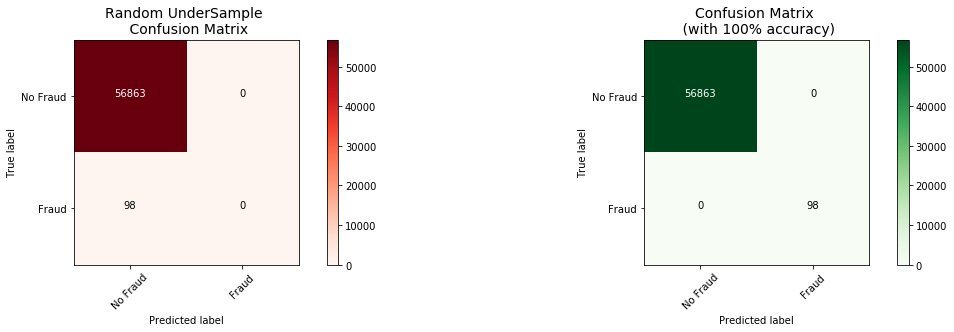

In [143]:
undersample_cm = confusion_matrix(original_Y_test, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_Y_test, original_Y_test)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras Oversampling (SMOTE)

In [145]:
n_inputs = Xsm_train.shape[1]

oversample_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [n_inputs]),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(2, activation = "softmax")
])

In [147]:
oversample_model.compile(loss='sparse_categorical_crossentropy', optimizer = "Adam", metrics=['accuracy'])

In [148]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 4s - loss: 6.1134 - acc: 0.6207 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 9/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 10/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 11/20
 - 4s - loss: 6.0443 - acc: 0.6250 - val_loss: 16.1181 -

In [151]:
oversample_predictions = model.predict(original_X_test, batch_size=200, verbose=0)

In [154]:
oversample_fraud_predictions = model.predict_classes(original_X_test, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56863     0]
 [   98     0]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


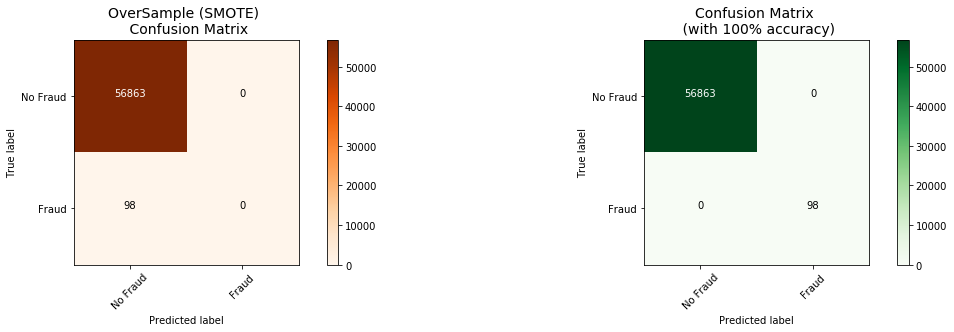

In [155]:
oversample_smote = confusion_matrix(original_Y_test, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_Y_test, original_Y_test)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)